# Lesson 04: Dense Word Representations (Embeddings)

In this lesson, we move beyond sparse representations (BoW, TF-IDF) to **dense vectors**.
We will explore how words can be represented as high-dimensional points in space, capturing semantic relationships through the "company they keep".

**Key Concepts**:
1. **Distributional Semantics**: "You shall know a word by the company it keeps" (Firth, 1957).
2. **Word2Vec**: Skip-gram and CBOW architectures.
3. **FastText**: Handling subwords and out-of-vocabulary (OOV) terms.
4. **GloVe**: Global vectors based on co-occurrence statistics.
5. **Dimensionality Reduction**: Visualizing embeddings with **t-SNE** and **UMAP**.
6. **Temporal Semantic Shifts**: Tracking word context evolution year-by-year (2021-2025).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from sklearn.manifold import TSNE
import umap
from adjustText import adjust_text
from scipy.linalg import orthogonal_procrustes
from pathlib import Path

# Add the module to path for imports to work
sys.path.append(str(Path.cwd().parent))
sys.path.append(str(Path.cwd().parent.parent))

from notebook_utils import path_resolver
from representations.embeddings import EmbeddingWrapper, get_word_vectors
from utils import get_improved_stopwords

# Set aesthetic style
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (12, 8)

## 1. Why Dense Representations?

Sparse representations (like BoW) have significant limitations:
- **High Dimensionality**: The vector size is equal to the vocabulary size (tens of thousands).
- **Sparsity**: Most entries are zero, which is computationally inefficient.
- **Lack of Semantics**: In BoW, "hotel" and "motel" are as different as "hotel" and "cat". There is no notion of similarity.
- **Synonymy/Polysemy**: Sparse models don't naturally capture that "amendă" and "sancțiune" are related.

**Dense Embeddings** solve this by mapping words to a low-dimensional space (e.g., 100-300 dimensions) where similar words are closer together.

## 2. Theoretical Foundations

### 2.1 Distributional Semantics
The core idea is that words used in similar contexts tend to have similar meanings. Modern embedding algorithms (Word2Vec, GloVe, FastText) all leverage this principle, but in different ways.

### 2.2 Word2Vec (Mikolov et al., 2013)
Word2Vec uses a shallow neural network to learn embeddings from local context windows. It offers two architectures:
- **Continuous Bag of Words (CBOW)**: Predicts a target word based on its context words. Faster, better for frequent words.
- **Skip-gram**: Predicts context words given a target word. Slower, but better for infrequent words and handles larger contexts well.

### 2.3 FastText (Bojanowski et al., 2017)
Developed by Facebook Research, FastText extends Word2Vec by representing each word as a bag of character n-grams.
- **Example**: "amendă" is broken into `<am`, `ame`, `men`, `end`, `ndă`, `dă>`.
- **Benefits**: 
    - **Morphology**: Captures common roots and suffixes (crucial for Romanian!).
    - **OOV (Out-of-Vocabulary)**: Can generate vectors for words not seen during training.

### 2.4 GloVe (Pennington et al., 2014)
**Global Vectors for Word Representation** focuses on global co-occurrence statistics.
- It builds a large $V \times V$ co-occurrence matrix $X$, where $X_{ij}$ is the number of times word $i$ appears in the context of word $j$.
- It optimizes word vectors such that their dot product matches the log of their co-occurrence probability.

## 3. Load and Prepare Data

We use the preprocessed ANPC dataset (2021-2025). 
To get high-quality representations, we use **lemmas** and filter by **Part-of-Speech (POS)** tags, keeping only content-bearing words (Nouns, Verbs, Adjectives, Proper Nouns).

In [2]:
data_path = "../02_data_preprocessing/data/processed/articles_anpc_preprocessed.json"
df = pd.read_json(path_resolver(data_path, external=True))
print(f"Loaded {len(df)} articles.")

# Prepare sentences using content_tokens and POS filtering
def get_cleaned_sentences(token_col):
    sentences = []
    for tokens in token_col:
        # Filter for NOUN, VERB, ADJ, PROPN and length > 2
        cleaned = [t['lemma'].lower() for t in tokens 
                  if t.get('pos') in ['NOUN', 'VERB', 'ADJ', 'PROPN'] 
                  and len(t['lemma']) > 2]
        sentences.append(cleaned)
    return sentences

# Combine title and content tokens for richer context
df['combined_tokens'] = df['title_tokens'] + df['content_tokens']
sentences = get_cleaned_sentences(df['combined_tokens'])

Loaded 237 articles.


## 4. Training Word2Vec & FastText

We train both models. Notice how the POS filtering helps in finding "real" neighbors.

In [3]:
# Training Word2Vec (Skip-gram)
w2v_wrapper = EmbeddingWrapper(model_type="word2vec", vector_size=100, window=10, min_count=3, sg=1, workers=4)
w2v_wrapper.train(sentences)

# Training FastText
ft_wrapper = EmbeddingWrapper(model_type="fasttext", vector_size=100, window=10, min_count=3, workers=4)
ft_wrapper.train(sentences)

print("Models trained successfully.")

Models trained successfully.


### 4.1 Grounded Similarities

Let's see what the model *actually* learned from the ANPC articles.

In [4]:
query_words = ["amendă", "energie", "produs", "control"]

for word in query_words:
    if word in w2v_wrapper.model.wv:
        print(f"\nMost similar to '{word}':")
        w2v_sim = w2v_wrapper.most_similar(word, topn=5)
        print(f"  [W2V]: {', '.join([f'{i['word']}' for i in w2v_sim])}")
    else:
        print(f"\nWord '{word}' not in vocabulary.")


Most similar to 'amendă':
  [W2V]: leu, contravențional, confisca, cuantum, adăuga

Most similar to 'energie':
  [W2V]: electric, sită, reducere, practica, furnizor

Most similar to 'produs':
  [W2V]: produce, carne, lactat, minimal, comercializare

Most similar to 'control':
  [W2V]: efectua, municipiu, operativ, vizat, acțiune


## 5. Analogy Solving (Grounded)

One of the most famous properties of Word2Vec is its ability to capture linear relationships between words.
**Example**: `rege` - `bărbat` + `femeie` $\approx$ `regină`.

In [5]:
# Working analogy: control is to amendă as verificare is to ?
print("Grounded Analogy:")
result = w2v_wrapper.analogy("control", "amendă", "verificare", topn=3)
if result:
    print(f"'control' is to 'amendă' as 'verificare' is to: {result[0]['word']}")

Grounded Analogy:
'control' is to 'amendă' as 'verificare' is to: avertisment


## 6. Visualization: t-SNE & UMAP

Visualizing high-dimensional embeddings requires dimensionality reduction. We explore two popular methods:

### 2.1 t-SNE (t-Distributed Stochastic Neighbor Embedding)
- **Goal**: Preserves **local structure**. Words that are neighbors in high-dimensional space remain neighbors in 2D.
- **Mechanism**: Uses a Student's t-distribution to calculate similarity.
- **Note**: t-SNE is **non-deterministic** (starts with random initialization) and can be sensitive to hyperparameters like `perplexity`.

### 2.2 UMAP (Uniform Manifold Approximation and Projection)
- **Goal**: Preserves both **local and global structure**. It tries to maintain the relative distances between clusters.
- **Mechanism**: Based on Riemannian geometry and algebraic topology.
- **Note**: Generally faster than t-SNE and more consistent across runs.

In [6]:
# Select words to visualize
stopwords = get_improved_stopwords()
vocab = list(w2v_wrapper.model.wv.index_to_key)
# Take some anchor words and some frequent words
anchors = ["amendă", "sancțiune", "energie", "gaz", "preț", "produs", "alimentar", "comisar", "consumator"]
others = [w for w in vocab if w not in anchors and w not in stopwords][:91]
visual_vocab = anchors + others
word_vectors = get_word_vectors(w2v_wrapper, visual_vocab)

/home/marius/ore/inlp/gh/inlp/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


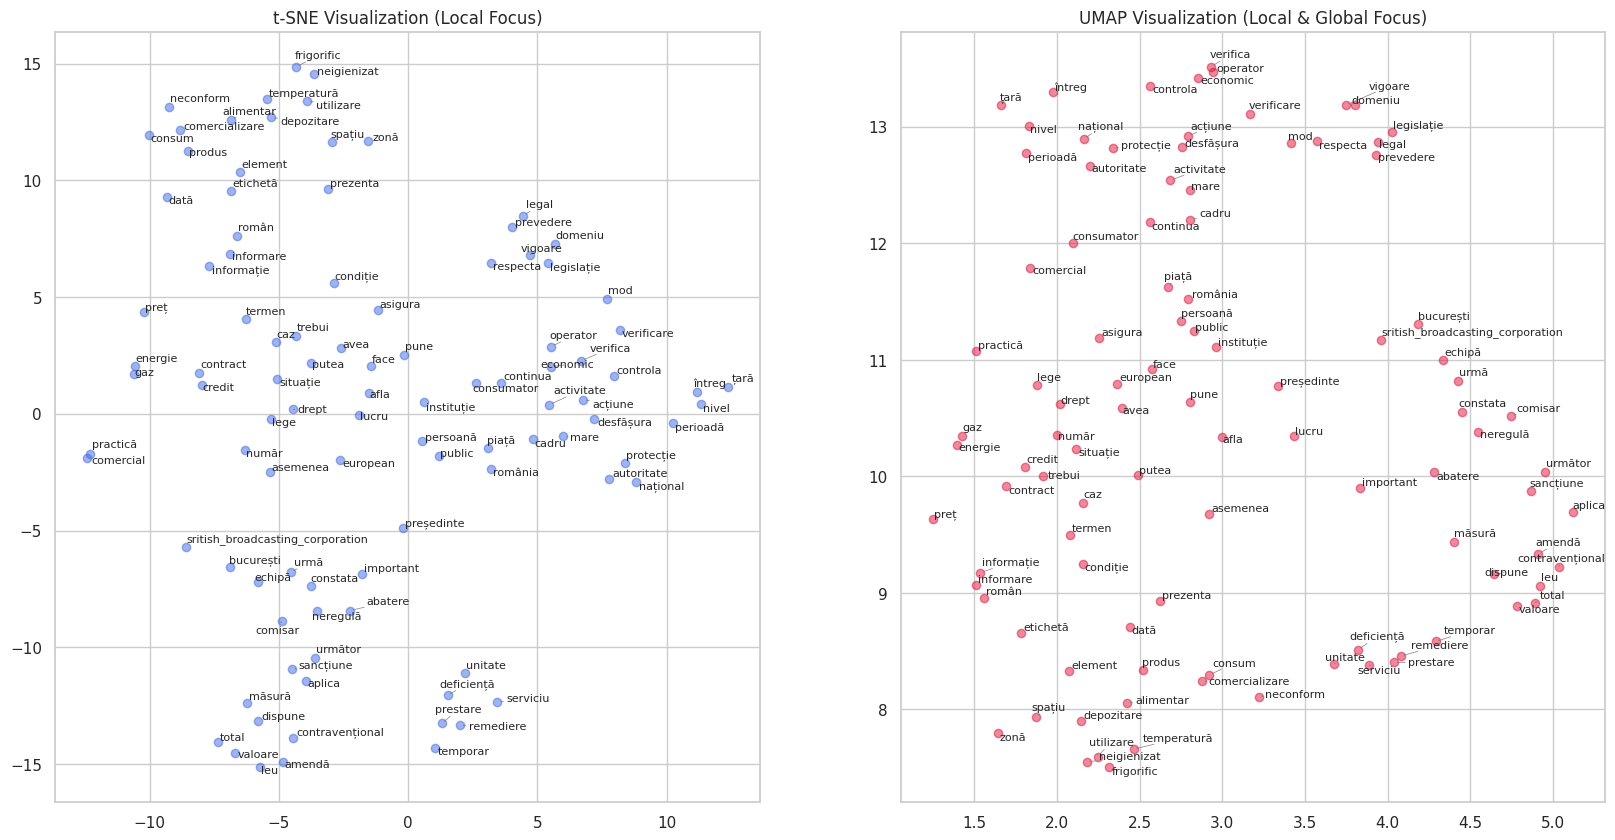

In [7]:
# t-SNE
tsne = TSNE(n_components=2, perplexity=15, max_iter=1000, random_state=42, init='pca', learning_rate='auto')
tsne_results = tsne.fit_transform(word_vectors)

# UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
umap_results = reducer.fit_transform(word_vectors)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Plot t-SNE
ax1.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.5, c='royalblue')
texts_tsne = [ax1.text(tsne_results[i, 0], tsne_results[i, 1], word, fontsize=8) for i, word in enumerate(visual_vocab)]
adjust_text(texts_tsne, ax=ax1, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))
ax1.set_title("t-SNE Visualization (Local Focus)")

# Plot UMAP
ax2.scatter(umap_results[:, 0], umap_results[:, 1], alpha=0.5, c='crimson')
texts_umap = [ax2.text(umap_results[i, 0], umap_results[i, 1], word, fontsize=8) for i, word in enumerate(visual_vocab)]
adjust_text(texts_umap, ax=ax2, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))
ax2.set_title("UMAP Visualization (Local & Global Focus)")

plt.show()

## 7. Temporal Semantic Trajectory (2021-2025)

Does the meaning of words evolve year-by-year? We track the "trajectory" of key words by training sequential models and aligning them using the **Orthogonal Procrustes** method.

In [8]:
df['date_iso'] = pd.to_datetime(df['date_iso'])
years = sorted(df['date_iso'].dt.year.unique())
print(f"Analyzing years: {years}")

# Train yearly models
yearly_models = {}
for year in years:
    df_year = df[df['date_iso'].dt.year == year]
    sentences_year = get_cleaned_sentences(df_year['combined_tokens'])
    model = EmbeddingWrapper(model_type="word2vec", vector_size=50, window=10, min_count=2, sg=1)
    model.train(sentences_year)
    yearly_models[year] = model

Analyzing years: [np.int32(2021), np.int32(2022), np.int32(2023), np.int32(2024), np.int32(2025)]


### Sequential Alignment
We align each year $t$ to year $t-1$ to ensure a consistent trajectory.

In [9]:
# Alignment function
def align_two_models(m1, m2):
    """Align m2 to m1 using Procrustes."""
    common_vocab = sorted(list(set(m1.model.wv.index_to_key) & set(m2.model.wv.index_to_key)))
    if not common_vocab:
        return m2.model.wv.vectors
    v1 = np.array([m1.model.wv[w] for w in common_vocab])
    v2 = np.array([m2.model.wv[w] for w in common_vocab])
    R, _ = orthogonal_procrustes(v2, v1)
    # Apply transformation to all vectors in m2
    return m2.model.wv.vectors @ R

# Perform sequential alignment
aligned_vectors = {years[0]: yearly_models[years[0]].model.wv}
for i in range(1, len(years)):
    prev_year = years[i-1]
    curr_year = years[i]
    # Create a new KeyedVectors-like object with aligned vectors
    aligned_v = align_two_models(yearly_models[prev_year], yearly_models[curr_year])
    # For simplicity in this demo, we'll store the transformation logic
    # In a full impl, we'd update the wv object.
    yearly_models[curr_year].aligned_vectors = aligned_v

### Visualizing the Trajectory
We track how "energie" and "control" move over 5 years.

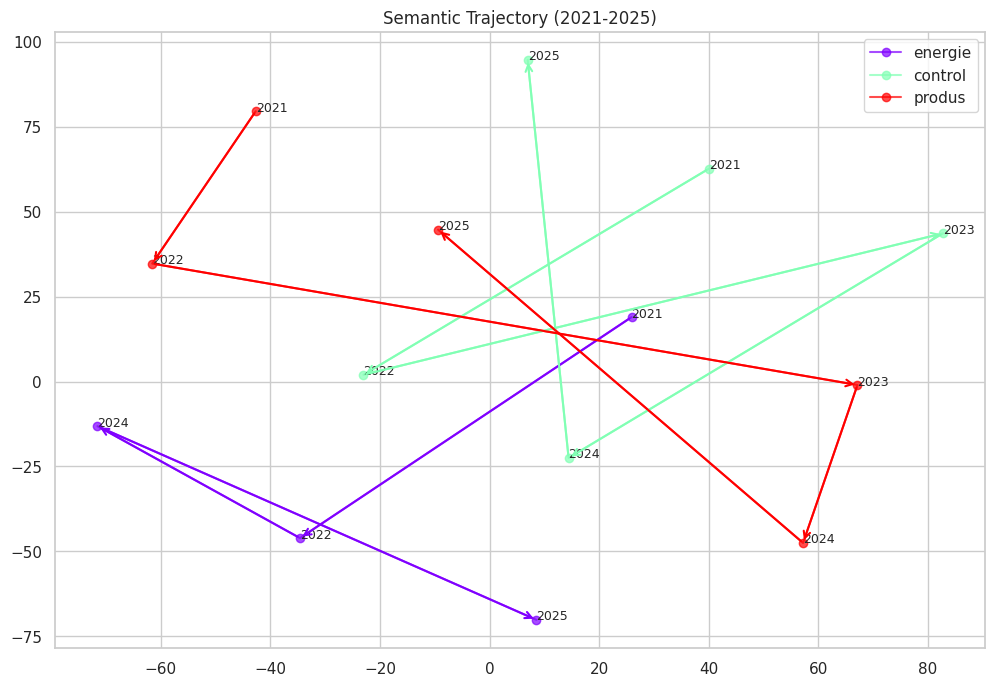

In [10]:
target_words = ["energie", "control", "produs"]
trajectories = {w: [] for w in target_words}

# Collect vectors (using aligned ones where available)
for year in years:
    model = yearly_models[year]
    for word in target_words:
        if word in model.model.wv:
            idx = model.model.wv.key_to_index[word]
            vec = model.aligned_vectors[idx] if hasattr(model, 'aligned_vectors') else model.model.wv[word]
            trajectories[word].append((year, vec))

# Combine all points for dimensionality reduction
all_points = []
labels = []
for word, pts in trajectories.items():
    for year, vec in pts:
        all_points.append(vec)
        labels.append(f"{word}_{year}")

pca_traj = TSNE(n_components=2, perplexity=len(labels)-1 if len(labels) < 30 else 30, random_state=42, init='pca', learning_rate='auto').fit_transform(np.array(all_points))

plt.figure(figsize=(12, 8))
colors = plt.cm.rainbow(np.linspace(0, 1, len(target_words)))

for i, (word, color) in enumerate(zip(target_words, colors)):
    word_pts = [pca_traj[j] for j, label in enumerate(labels) if label.startswith(word)]
    word_pts = np.array(word_pts)
    plt.plot(word_pts[:, 0], word_pts[:, 1], marker='o', color=color, label=word, alpha=0.7)
    for k, (year, _) in enumerate([pt for pt in trajectories[word]]):
        plt.text(word_pts[k, 0], word_pts[k, 1], str(year), fontsize=9)
        if k > 0: # Add arrow
            plt.annotate('', xy=word_pts[k], xytext=word_pts[k-1], arrowprops=dict(arrowstyle='->', lw=1.5, color=color))

plt.title("Semantic Trajectory (2021-2025)")
plt.legend()
plt.show()

---
## Exercises

### Exercise 1: Multi-Year Drift Impact
Which word moved the most in the vector space between 2021 and 2025? Use Euclidean distance between aligned vectors to find the word with the highest "drift score".

### Exercise 2: Document Centroids by Year
Calculate the average vector of all documents in 2021 vs 2024. Does the "average press release" move in semantic space?

### Exercise 3: Hyperparameter Impact
Try training with `sg=0` (CBOW) vs `sg=1` (Skip-gram). Which one provides more intuitive neighbors for rare words in the ANPC dataset?